In [48]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
import tdt
import trompy as tp

import dill

In [3]:
DATAFOLDER = Path("..\\data")
df = pd.read_excel("..\\experiment_info_gsheet.xlsx", sheet_name="Sheet1")

In [6]:
# this function should get snips from the tank
# should add pre, post and other functions
def get_snips(tank):
    # preprocess streams
    
    data = tdt.read_block(tank)
    blue = data.streams["x65A"].data
    uv = data.streams["x05A"].data
    fs = data.streams["x05A"].fs
    
    filtered_sig = tp.processdata(blue, uv, fs=fs)
    
    # get epochs
    sol = data.epocs.Sper.onset
    
    #make snips
    snips = tp.snipper(filtered_sig, sol, fs=fs, pre=10, post=20, bins=300)[0]
    
    # baseline correction - correct to minimum value in the pre period
    snips = snips - snips[:, :100].min(axis=1)[:, None]
    # and maybe scale them so they all go between -1 and 1 based on the same parameters
    
    # return snips
    return snips

TANK = str(DATAFOLDER / "Svg130-210727-115203")
snips = get_snips(TANK)

read from t=0s to t=1517.88s


In [7]:
snips_dict = {}
for row in df.iterrows():
    TANK = str(DATAFOLDER / row[1].tank)
    snips = get_snips(TANK)
    
    snips_dict[f"{row[1].rat}_{row[1].condition}"] = snips

read from t=0s to t=1517.88s
read from t=0s to t=1542.9s
read from t=0s to t=1540.93s
read from t=0s to t=1599.41s
read from t=0s to t=1783.28s
read from t=0s to t=1523.62s
read from t=0s to t=1672.54s
read from t=0s to t=1559.22s
read from t=0s to t=1517.06s
read from t=0s to t=1544.24s
read from t=0s to t=1528.5s
read from t=0s to t=1584.56s


In [8]:
with open(DATAFOLDER / "snips_dict.pickle", "wb") as f:
    dill.dump(snips_dict, f)

In [4]:
def snips_fig(snips):
    fig, ax = plt.subplots()
    for snip in snips:
        ax.plot(snip, color="black", alpha=0.3)

    ax.plot(np.mean(snips, axis=0))
    
def snips_changing_baseline_fig(snips, highlights=[]):
    fig, ax = plt.subplots()
    for idx, snip in enumerate(snips):
        if idx in highlights:
            ax.plot(snip+idx, color="red", alpha=0.99)
        else:
            ax.plot(snip+idx, color="black", alpha=0.3)


def heatmap(snips):
    fig, ax = plt.subplots()
    sns.heatmap(snips, cmap="Greys", ax=ax, vmin=0, vmax=5)
    
    

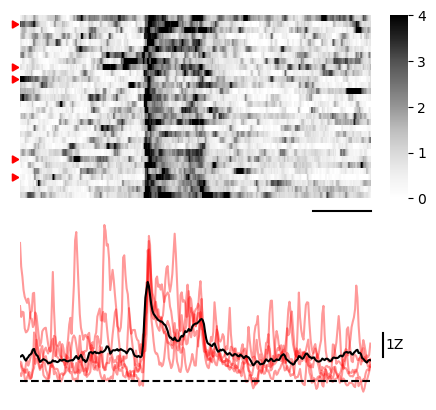

In [68]:
snips = snips_dict["SVG135_FD"]
highlights = [1, 8, 10, 23, 26]

f, [[ax1, ax2],
    [ax3, ax4]] = plt.subplots(nrows=2, ncols=2,
                     gridspec_kw={'width_ratios': [20, 1],
                                  "hspace": 0.1,
                                  "wspace": 0.1},
                     figsize=(5, 5),
                     )

sns.heatmap(snips, cmap="Greys", ax=ax1, vmin=0, vmax=4, cbar_ax=ax2)
ax1.set_xticks([])
ax1.set_yticks([])

right_triangle = MarkerStyle(marker=(3, 0, -90))
for hl in highlights:
    ax1.plot(-5, hl+0.5, marker=right_triangle, color="red", zorder=20, clip_on=False)

ax1.plot((250, 300), (32, 32), color="black", clip_on=False)
ax1.text(275, 33, "5 s", ha="center", va="top")


for hl in highlights:
    ax3.plot(snips[hl,:], color="red", alpha=0.4)

ax3.plot(np.mean(snips, axis=0), color="black")
ax3.set_xticks([])
ax3.set_yticks([])
ax3.sharex(ax1)
ax3.axhline(0, linestyle="--", color="black")

for spines in ["top", "right", "left", "bottom"]:
    ax3.spines[spines].set_visible(False)

ax3.plot((310, 310), (1, 2), color="black", clip_on=False)
ax3.text(312, 1.5, "1Z", ha="left", va="center")

ax4.remove()


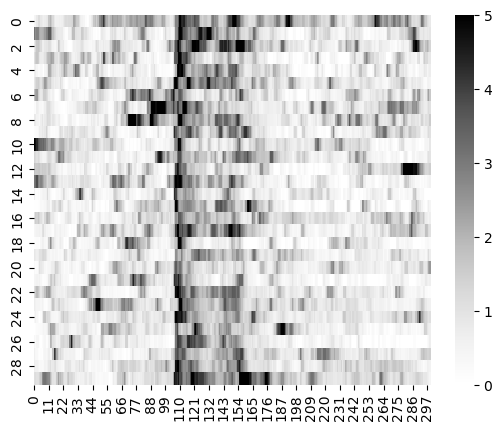

In [41]:
heatmap(snips_dict["SVG135_FD"])

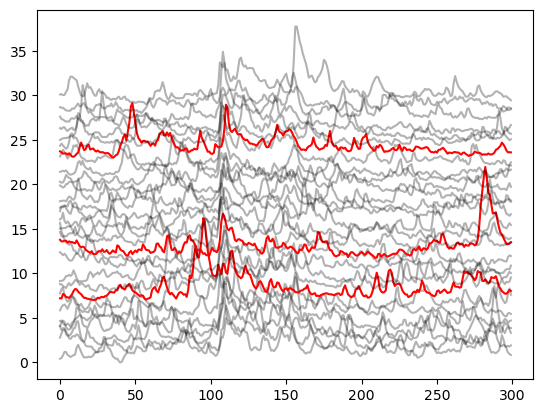

In [47]:
snips_changing_baseline_fig(snips_dict["SVG135_FD"], highlights=[7, 12, 23])

In [21]:
snips_dict.keys()

dict_keys(['0_FD', '1_adlib', '2_adlib', '3_FD', '4_FD', '5_adlib', '6_adlib', '7_FD', '8_FD', '9_adlib', '10_adlib', '11_FD'])

In [ ]:
for key, snips in snips_dict.items():
    fig = snips_fig(snips)
    
    fig = heatmap(snips)
    fig.savefig(f"{key}_heatmap.png")
    plt.close(fig)

In [18]:
def calculate_minima(data, window_size):
    """
    Calculate the rolling minima over a specified window size.

    Parameters:
    data (pd.Series or pd.DataFrame): The input data.
    window_size (int): The size of the rolling window.

    Returns:
    pd.Series or pd.DataFrame: The rolling minima.
    """
    return data.rolling(window=window_size).min()

calculate_minima(pd.Series(snips[0,:]), 10)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
295    0.471980
296    0.518663
297    0.553180
298    0.553180
299    0.717358
Length: 300, dtype: float64

In [16]:
snips[0,:].shape

(300,)

In [14]:
data = tdt.read_block(str(DATAFOLDER / "LickVK-210727" / "Svg130-210727-115203"))

# tdt.read_block("C:\\Users\\jmc010\\Github\\time-averaged-da\\data\\LickVK-210727\\LickVK-210727\\Svg130-210727-115203")

read from t=0s to t=1517.88s


In [17]:
data.epocs.Sper.onset

array([  46.90722816,   86.91679232,  131.92658944,  181.936128  ,
        231.9458304 ,  291.95534336,  351.96502016,  411.97436928,
        451.98409728,  501.99379968,  552.00350208,  607.01310976,
        647.02267392,  687.03240192,  732.04219904,  782.0517376 ,
        832.06127616,  887.07072   ,  932.08051712,  992.09019392,
       1032.09975808, 1092.10943488, 1152.11894784, 1197.12841728,
       1242.1382144 , 1297.14782208, 1337.15755008, 1382.16718336,
       1432.17688576, 1477.18651904])

In [19]:
data.streams

x05A	[struct]
x65A	[struct]
Fi1d	[struct]
Fi1r	[struct]

In [21]:
blue = data.streams.x65A.data
uv = data.streams.x05A.data
fs = data.streams.x65A.fs

processed_signal = tp.processdata(blue, uv, fs=fs)

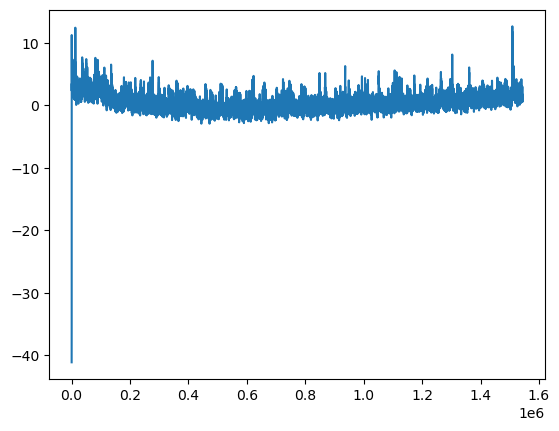

In [22]:
import matplotlib.pyplot as plt

plt.plot(processed_signal)